In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Dropout,Input, Bidirectional
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

from google.colab import drive
df= drive.mount('/content/Subjectall_combined_3_trials_time.csv')
 #Load the dataset from Excel file
data = pd.read_csv('/content/Subjectall_combined_3_trials_time.csv/MyDrive/Subjectall_combined_3_trials_time.csv')

Mounted at /content/Subjectall_combined_3_trials_time.csv


In [ ]:
data.head()

,A,B,C,D,E,F,G,H,I
0,0,0,185,70,1.6904,27.107,6.0707,-17.985,-17.75
1,1,1,185,70,1.6904,27.207,7.9505,-18.089,165.24
2,2,2,185,70,1.6904,27.098,8.8231,-19.218,340.79
3,3,3,185,70,1.6904,26.892,8.9305,-21.367,493.32
4,4,4,185,70,1.6904,26.744,9.0049,-24.032,615.08


In [ ]:
data.tail()

,A,B,C,D,E,F,G,H,I
3025,96,96,180,74,1.1152,34.787,8.3381,-17.177,0.0
3026,97,97,180,74,1.1152,34.236,7.0385,-17.853,0.0
3027,98,98,180,74,1.1152,33.858,6.7574,-18.278,0.0
3028,99,99,180,74,1.1152,33.663,7.6665,-17.991,0.0
3029,100,100,180,74,1.1152,33.511,9.5182,-17.296,0.0


In [ ]:
# Assuming columns 3 to 5 are input features and the last column is the target(GRF)
X = data.iloc[:, 2:6].values  # Input features
Y = data.iloc[:, -1].values.reshape(-1, 1)  # Target

In [ ]:
#Preparing the Data
T=1
D=X.shape[1]
N= len(X)-T
Ntrain = len(X)*2//3

# Normalizing the Data
scaler = MinMaxScaler(feature_range=(0,1))
scalar= StandardScaler
Y_scaled= scaler.fit_transform(np.array(Y).reshape(-1,1))
X_scaled = scaler.fit_transform(X)

#Setup X_train and Y_train
X_train= np.zeros((Ntrain,T,D))
Y_train= np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:]= X_scaled[t:t+T]
  Y_train[t]= Y_scaled[t:t+T]

#Setup X_test and Y_test
X_test = np.zeros((N-Ntrain,T,D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N

  t = u + Ntrain
  X_test[u,:,:]= X_scaled[t:t+T]
  Y_test[u]= Y_scaled[t:t+T]

# X_test= scaler.fit_transform(X_test[:Ntrain+T-1])

# Reshape for input features of LSTM[ samples, timesteps, features]
X_reshaped = X_scaled.reshape((X.shape[0], 1, X.shape[1]))

D=X_scaled.shape[1]

print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (3030, 4) Y.shape (3030, 1)


<ipython-input-7-122a388b8c7c>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_train[t]= Y_scaled[t:t+T]
<ipython-input-7-122a388b8c7c>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_test[u]= Y_scaled[t:t+T]


In [ ]:
X_reshaped

array([[[0.9       , 0.25925926, 0.77729078, 0.70138751]],

       [[0.9       , 0.25925926, 0.77729078, 0.70271526]],

       [[0.9       , 0.25925926, 0.77729078, 0.70126801]],

       ...,

       [[0.73333333, 0.33333333, 0.38337214, 0.79102436]],

       [[0.73333333, 0.33333333, 0.38337214, 0.78843524]],

       [[0.73333333, 0.33333333, 0.38337214, 0.78641705]]])

In [ ]:
Y_train,len(Y_train)

(array([0.0058205 , 0.14004775, 0.2688176 , ..., 0.01884052, 0.01884052,
        0.01884052]),
 2020)

In [ ]:
len(Y_test),Y_test

(1009,
 array([0.03850112, 0.09553028, 0.15602387, ..., 0.01884052, 0.01884052,
        0.01884052]))

In [ ]:
X_train,len(X_train)

(array([[[0.9       , 0.25925926, 0.77729078, 0.70138751]],
 
        [[0.9       , 0.25925926, 0.77729078, 0.70271526]],
 
        [[0.9       , 0.25925926, 0.77729078, 0.70126801]],
 
        ...,
 
        [[1.        , 0.05555556, 0.93877551, 0.7302131 ]],
 
        [[1.        , 0.05555556, 0.93877551, 0.72808869]],
 
        [[1.        , 0.05555556, 0.93877551, 0.72470291]]]),
 2020)

In [ ]:
len(X_test), X_test

(1009,
 array([[[1.        , 0.05555556, 0.67162033, 0.73508597]],
 
        [[1.        , 0.05555556, 0.67162033, 0.73758215]],
 
        [[1.        , 0.05555556, 0.67162033, 0.7408086 ]],
 
        ...,
 
        [[0.73333333, 0.33333333, 0.38337214, 0.79604328]],
 
        [[0.73333333, 0.33333333, 0.38337214, 0.79102436]],
 
        [[0.73333333, 0.33333333, 0.38337214, 0.78843524]]]))

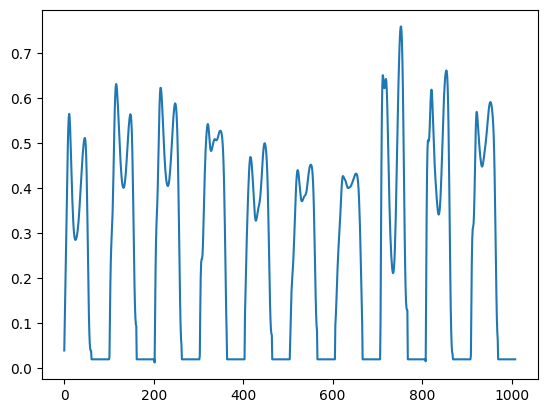

In [ ]:
plt.plot(Y_test)

In [ ]:
X_train.shape

(2020, 1, 4)

In [ ]:
# T is the number of time steps and D is the number of features per time step

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(T, D)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))  # Output layer for regression

model.compile(
    loss='mse',
    optimizer= Adam(learning_rate=0.001),
    metrics= ['MAE']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 128)            35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [ ]:
# Train the model
r= model.fit(
    X_train,Y_train,
    epochs= 400,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=1
          )

Epoch 1/400
64/64 [==============================] - 1s 9ms/step - loss: 0.0585 - MAE: 0.2125 - val_loss: 0.0406 - val_MAE: 0.1830
Epoch 2/400
64/64 [==============================] - 1s 9ms/step - loss: 0.0579 - MAE: 0.2113 - val_loss: 0.0405 - val_MAE: 0.1831
Epoch 3/400
64/64 [==============================] - 1s 10ms/step - loss: 0.0580 - MAE: 0.2116 - val_loss: 0.0403 - val_MAE: 0.1812
Epoch 4/400
64/64 [==============================] - 1s 9ms/step - loss: 0.0579 - MAE: 0.2116 - val_loss: 0.0404 - val_MAE: 0.1828
Epoch 5/400
64/64 [==============================] - 1s 9ms/step - loss: 0.0579 - MAE: 0.2115 - val_loss: 0.0406 - val_MAE: 0.1831
Epoch 6/400
64/64 [==============================] - 1s 14ms/step - loss: 0.0583 - MAE: 0.2131 - val_loss: 0.0406 - val_MAE: 0.1832
Epoch 7/400
64/64 [==============================] - 1s 14ms/step - loss: 0.0577 - MAE: 0.2105 - val_loss: 0.0405 - val_MAE: 0.1824
Epoch 8/400
64/64 [==============================] - 1s 14ms/step - loss: 0.0580

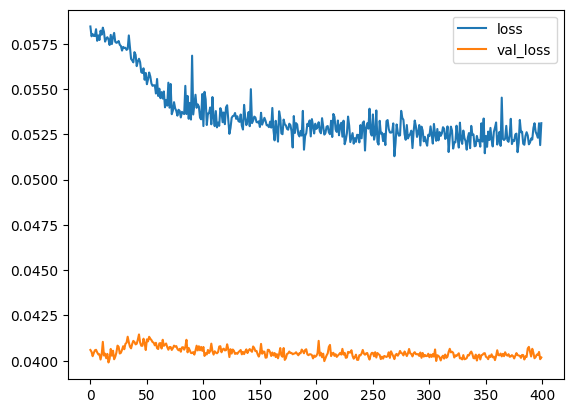

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
train_rmse = mean_squared_error(Y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(Y_test, test_predictions, squared=False)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

train_predictions, test_predictions

y_pred= model.predict(X_test)

32/32 [==============================] - 0s 5ms/step
Train RMSE: 0.22503646733726665
Test RMSE: 0.19974880135340897
32/32 [==============================] - 0s 4ms/step


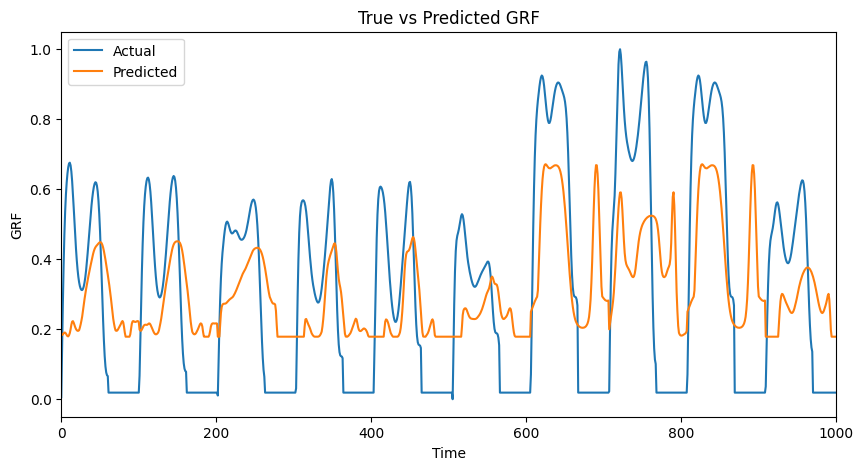

In [ ]:
# Plot the results

plt.figure(figsize=(10,5))
plt.plot(Y_scaled, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.xlim(0,1000)  # Set x-axis limits from 0 to  1000
plt.legend()
plt.xlabel('Time')
plt.ylabel('GRF')
plt.title('True vs Predicted GRF')
plt.show()

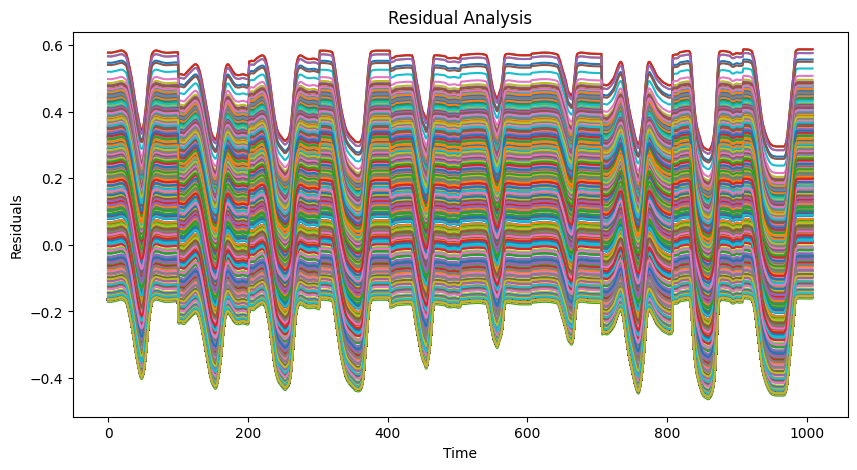

In [ ]:
residuals = Y_test - y_pred
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

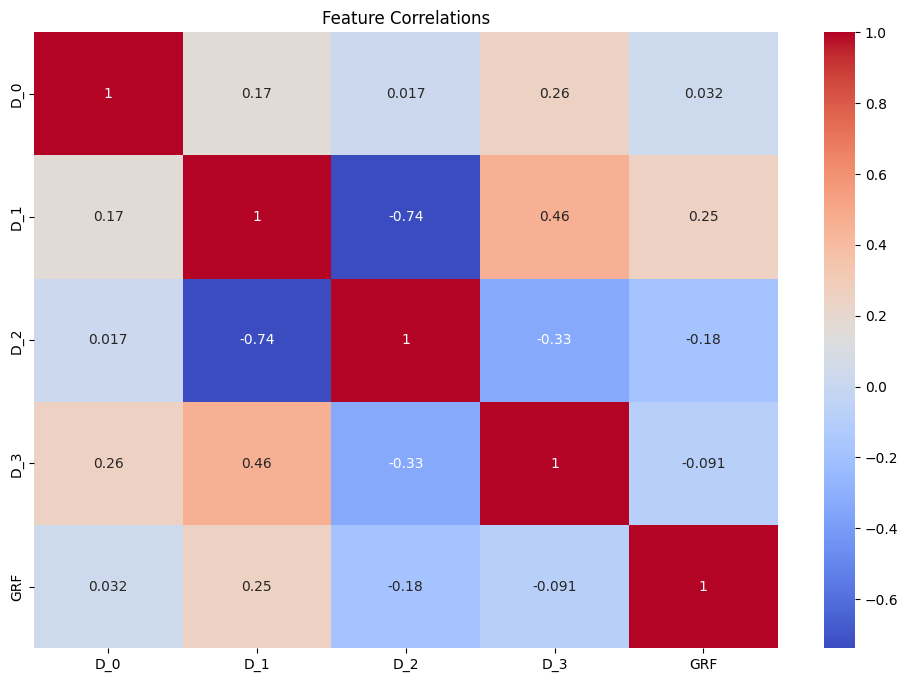

In [ ]:
# Feature Correlation Analysis
import pandas as pd
import seaborn as sns

data = pd.DataFrame(X_train.reshape(-1, D), columns=[f'D_{i}' for i in range(D)])
data['GRF'] = y_train

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()